# Descrição do problema

Uma posição _volátil_, no futebol (tanto no Brasil quanto fora), é a posição de técnico. Uma prática comum é substituir o treinador após alguns resultados negativos. Naturalmente, um time que não troca o técnico não é garantia de sucesso no campeonato. Assim, surge a dúvida: 

> Será que, **em geral**, times com técnicos mais longevos ficam em uma posição melhor na tabela, no fim do campeonato?

# Resolução do projeto

## Primeiros Passos

Dentre os requisitos do projeto, temos uma limitação quanto a utilizar somente o que foi aprendido em sala de aula. A solução a seguir, portanto, não se aprofunda no uso das bibliotecas `pandas` e `matplotlib`, nem em conceitos de POO (Programação Orientada a Objetos). O objetivo é responder à pergunta do enunciado utilizando somente os fundamentos de Python.

Quanto às bibliotecas importadas, temos que:

- `pandas` Empregada exclusivamente para a leitura de dados de um arquivo JSON e para a apresentação dos resultados por meio de estruturas tabulares (*dataframes*).
- `matplotlib` Empregada para a apresentação de gráficos simples, conforme especificado no enunciado do projeto.
- `pprint` Empregada para imprimir dicionários na tela de maneira mais legível.
- `functools` Empregada para a realização de cálculos durante a classificação das equipes.
- `random` Empregada para a realização de cálculos durante a classificação das equipes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from functools import reduce
from random import random

Dando início à resolução do problema, o primeiro passo é ler e armazenar os dados do arquivo JSON referente ao campeonato em questão. 

Para isso, utilizei o pandas para fazer a leitura dos dados e criei uma *list comprehension* para armazená-los em uma estrutura de matriz. Essa abordagem permite a manipulação ágil e concisa dos dados, facilitando assim as etapas subsequentes do projeto.

In [2]:
dados = pd.read_json('brasileirao-2019.json')
campeonato = [[dados[coluna][linha] for linha in dados.index] for coluna in dados.columns]

Cada elemento da matriz `campeonato` é um dicionário que contém as seguintes chaves e valores:

|Chaves | Valores |
|:------|-----------|
|clubs|Nomes dos times que se enfrentaram|
|goals|Placar do jogo|
|cards|Quantidade de cartões no jogo|
|hour|Horário do jogo|
|date|Data do jogo| 
|coach|Técnico dos times|
|formation|Táticas utilizadas no jogo|
|goalsPlayer|Nomes dos jogadores que marcaram gols|
|stadium|Estádio onde foi realizada a partida|
|stats|Estatísticas* da partida.

Os valores também são dicionários, cujas chaves são `home` e `away`, nesta ordem. Elas acessam as informações dos times da casa e de fora, respectivamente.

*Aqui temos informações sobre a quantidade de chutes, chutes a gol, posse de bola, passes, precisão de passe, faltas, cartões amarelos, cartões vermelhos, impedimentos e escanteios.

## Análise do problema

Analisar a correlação entre a longevidade do técnico e a colocação do time no campeonato leva aos seguintes questionamentos:

- Um técnico que foi demitido de um time durante o campeonato, pode ser contratado por outro time durante este mesmo campeonato?
- Qual a quantidade de rodadas (frequência) que cada técnico jogou para o seu time?
- Como é calculada a pontuação do time no campeonato?
- Será que o técnico mais longevo foi o que mais contribuiu para a pontuação final do time?
- Quantos pontos cada técnico trouxe ao seu time?
- Qual foi a pontuação dos times no campeonato?
- Quais são os critério de desempate, no caso de empate da pontuação?
- Como são calculados os critérios de desempate? Em qual ordem são definidos?
- Qual foi a classificação do campeonato?

## Definição de funções

A fim de responder as questões levantadas anteriormente, e pensando na manutenibilidade do código, foram criadas funções para:

1. Extrair os dados necessários para cada análise, de modo flexível.
2. Calcular o placar da partida para os casos de vitória, empate e derrota.
3. Calcular a frequência do técnico em cada time.
4. Calcular a pontuação que cada técnico obteve durante sua estadia no time.
5. Calcular a pontuação final do time no campeonato e calcular cada valor dos critérios de desempate.
6. Classificar os times no campeonato.
7. Definir a classificação de acordo com a ordem dos critérios de desempate.
8. Retornar o valor correto para os casos de confronto direto entre dois times no campeonato.

Todas as funções estão bem documentadas, fazendo uso de *type hints* e *docstrings*.

A partir dessas funções, podemos obter os dados necessários para, posteriormente, gerar tabelas e gráficos que forneçam *insights* para responder à dúvida do enunciado.

### Função para extração dados

Esta função permite extrair dados de uma matriz normalizada relacionada aos campeonatos. 

A função recebe uma matriz contendo todas as partidas do campeonato como argumento posicional. Ela oferece a flexibilidade de filtrar as partidas com base em diferentes critérios, como time, time adversário, local onde os jogos foram realizados (em casa ou fora), técnico, data e estádio.

Ao utilizar o parâmetro opcional `dados_da_partida`, é possível especificar as informações a serem extraídas, personalizando assim o resultado conforme a necessidade. As opções incluem dados sobre os clubes envolvidos, placar do jogo, quantidade de cartões, horário, data, técnico, táticas utilizadas, jogadores que marcaram gols, estádio e estatísticas detalhadas da partida.

In [3]:
def extracao_dados(mat: list, *dados_da_partida: str, time="", time_contra="", local="", tecnico="", data="", estadio="") -> list:
    """    
    Extrai apenas os dados informados de uma matriz normalizada para campeonatos.
    Retorna uma lista, sendo cada elemento um dicionário ou conjunto de dicionários contendo os dados de todos as partidas referentes aos argumentos passados.

    Parâmetros:
    ------

        `mat`: posicional, recebe uma matriz com todas as partidas do campeonato.
        `dados_da_partida`: opcional, recebe as informações que serão extraídas. 
        `time`: nomeado, recebe uma string para filtrar as partidas por time.
        `time_contra`: nomeado, recebe uma string para filtrar as partidas por time x time_contra. Deve ser passado junto com o argumento time.
        `local`: nomeado, recebe uma string para filtrar as partidas por local dos jogos, podendo ser "casa" ou "fora". Deve ser passado junto com o argumento time.
        `tecnico`: nomeado, recebe uma string para filtrar as partidas por tecnico.
        `data`: nomeado, recebe uma string para filtrar as partidas por data.
        `estadio`: nomeado, recebe uma string para filtrar as partidas por estádio.

    Dados que podem ser extraídos:
    ------

        `clubs`: nomes dos times que se enfrentaram.
        `goals`: placar do jogo.
        `cards`: quantidade de cartões no jogo.
        `hour`: horário do jogo.
        `date`: data do jogo.
        `coach`: técnico dos times.
        `formation`: táticas utilizada no jogo.
        `goalsPlayer`: nomes dos jogadores que marcaram gols.
        `stadium`: estádio onde foi realizada a partida.
        `stats`: estatísticas da partida. Aqui temos informações sobre a quantidade de chutes, chutes a gol, posse de bola, passes, precisão de passe, faltas, cartões amarelos, cartões vermelhos, impedimentos e escanteios.
    """
    
    local = "home" if local == "casa" else "away" if local == "fora" else ""
    partidas = list()

    idx_partidas = {
        "time": set(),
        "time_contra": set(),
        "home": set(),
        "away": set(),
        "tecnico": set(),
        "data": set(),
        "estadio": set()
    }

    contador = 0
    for linha in mat:
        for partida in linha:
            
            partidas.append(partida)
            
            if time and time in partida["clubs"].values():
                idx_partidas["time"].add(contador)
                if local and time in partida["clubs"][local]:
                    idx_partidas[local].add(contador)
            if time_contra and time_contra in partida["clubs"].values():
                idx_partidas["time_contra"].add(contador)
            if tecnico and tecnico in partida["coach"].values():
                idx_partidas["tecnico"].add(contador)
            if data and data == partida["date"]:
                idx_partidas["data"].add(contador)
            if estadio and estadio == partida["stadium"]:
                idx_partidas["estadio"].add(contador)
                
            contador += 1

    indices = set()
    for idx in idx_partidas.values():
        if idx:
            indices.update(idx) if not indices else indices.intersection_update(idx)

    if dados_da_partida:
        for dado in dados_da_partida:
            if dado not in partida:
                raise KeyError("Utilize somente os dados informados na docstring para extrair as informações desejadas, ex: 'clubs', 'goals', 'cards', etc.")
        is_filtrado = sum(bool(elemento) for elemento in idx_partidas.values())
        if is_filtrado:
            resultados = list(zip(*[[partidas[i][dado] for i in indices] for dado in dados_da_partida]))
        else: 
            resultados = list(zip(*[[partida[dado] for partida in partidas] for dado in dados_da_partida]))
    else:
        resultados = [partidas[i] for i in indices]
        
    return resultados

### Função para definir o placar

Esta função tem como principal objetivo centralizar o cálculo do placar em uma única variável. Ao receber os valores numéricos correspondentes aos pontos por vitória, empate e derrota, a função retorna uma lista contendo as pontuações associadas a cada cenário nas partidas do campeonato. 

O uso dessa função contribui para a clareza e modularidade do código, facilitando a manutenção e ajuste dos critérios de pontuação no contexto do campeonato.

In [4]:
def calc_placar(vitoria: int, empate: int, derrota: int) -> list:
    """ 
    Tem como objetivo centralizar o placar em uma variável.
    Retorna uma lista contendo as pontuações para os casos de vitória, empate e derrota nas partidas do campeonato.

    Parâmetros:
    ------

        `vitoria`: posicional, recebe um número inteiro para os pontos por vitória.
        `empate`: posicional, recebe um número inteiro para os pontos por empate.
        `derrota`: posicional, recebe um número inteiro para os pontos por derrota.
    """
    return [vitoria, empate, derrota]

### Função para calcular a frequência dos técnicos

Esta função tem como finalidade calcular a frequência de cada técnico em relação aos times do campeonato. O resultado é apresentado em forma de dicionário, onde as chaves são os times ou técnicos, dependendo do argumento fornecido em `filtro`.

Além disso, é possível utilizar os parâmetros `time`, `tecnico` e `longevidade` para refinar ainda mais os resultados, filtrando a frequência com base em um time ou técnico específicos, ou uma longevidade mínima.

In [5]:
def frequencia_tecnicos(mat: list, filtro="time", time="", tecnico="", longevidade=0) -> dict:
    """
    Calcula a frequência de cada técnico em relação ao time. 
    Retorna um dicionário cujas chaves são os times ou os técnicos, a depender do argumento passado como filtro.

    Parâmetros:
    ------

        `mat`: posicional, recebe uma matriz com todas as partidas do campeonato.
        `filtro`: nomeado, recebe uma string que define como será organizado o dicionário. Opções disponíveis: "time" (default) e "tecnico". Caso seja passado algum argumento inválido, será retornado um dicionário organizado por times como chaves.
        `time`: nomeado, recebe uma string que filtra o resultado por time.
        `tecnico`: nomeado, recebe uma string que filtra o resultado por tecnico.
        `longevidade`: nomeado, recebe um inteiro que filtra o resultado por frequência maior ou igual ao número passado.
    """
    filtro = "time" if (time or filtro == time) else "tecnico" if (tecnico or filtro == "tecnico") else "time"
        
    resultado = {}
    partidas = extracao_dados(mat, "clubs", "coach")
    
    for partida in partidas:
        times, tecnicos = partida
        
        # uma iteração para o time da casa, outra para o time visitante
        for i in range(2):
            local = "home" if i == 0 else "away"
            
            if filtro == "tecnico":
                # cria a estrutura do dicionário tecnico > time > frequência
                resultado.setdefault(tecnicos[local], dict()).setdefault(times[local], 0)
                # atualiza os valores
                resultado[tecnicos[local]][times[local]] += 1                
            else:
                # cria a estrutura do dicionário time > técnico > frequência
                resultado.setdefault(times[local], dict()).setdefault(tecnicos[local], 0)
                # atualiza os valores
                resultado[times[local]][tecnicos[local]] += 1

    if longevidade:
        try:
            not_longevos = []
            
            for chave_1, valor in resultado.items():
                for chave_2, frequencia in valor.items():
                    if frequencia < longevidade:
                        not_longevos.append((chave_1, chave_2))
            for chave_1, chave_2 in not_longevos:
                resultado[chave_1].pop(chave_2)

            resultado = {chave:valor for chave, valor in resultado.items() if valor}
        except TypeError:
            raise TypeError("Informe apenas números para a longevidade.")
    if time:
        try:
            return resultado[time]
        except KeyError:
            return {}
    if tecnico:
        try:
            return resultado[tecnico]
        except KeyError:
            return {}
    
    return resultado

### Função para calcular a pontuação dos times por técnico

Esta função tem como objetivo calcular a pontuação atribuída por cada técnico ao seu time durante o campeonato.

Ela recebe uma matriz com todas as partidas do campeonato, e uma lista contendo os pontos correspondentes a vitória, empate e derrota, respectivamente. O parâmetro `filtro` determina se a saída será organizada por time ou por técnico, com a opção padrão sendo "time" caso nenhum valor seja especificado.

Adicionalmente, é possível filtrar os resultados com base em um time ou técnico específicos, ou uma pontuação mínima. 

In [6]:
def pontuacao_tecnicos(mat: list, placar: list, filtro="time", time="", tecnico="", minimo=0) -> dict:
    """
    Calcula a pontuação que cada técnico obteve para o time. 
    Retorna um dicionário cujas chaves são os times ou os técnicos, a depender do argumento passado como filtro.

    Parâmetros:
    ------

        `mat`: posicional, recebe uma matriz com todas as partidas do campeonato.
        `placar`: posicional, recebe um lista contendo 3 elementos, referente aos pontos de vitória, empate e derrota, respectivamente.
        `filtro`: nomeado, recebe uma string que define como será organizado o dicionário. Opções disponíveis: "time" (default) e "tecnico". Caso seja passado algum argumento inválido, será retornado um dicionário organizado por times como chaves.
        `time`: nomeado, recebe uma string que filtra o resultado por time.
        `tecnico`: nomeado, recebe uma string que filtra o resultado por tecnico.
        `minimo`: nomeado, recebe um inteiro que filtra o resultado por pontuação maior ou igual ao número passado.
    """
    # verificando integridade do placar
    if len(placar) != 3:
        raise ValueError("O placar deve contar exatamente 3 números, representando os pontos de vitória, empate e derrota, respectivamente.")
    elif (not isinstance(placar[0], int)) or (not isinstance(placar[1], int)) or (not isinstance(placar[2], int)):
        raise TypeError("O placar deve conter apenas números inteiros.")

    filtro = "time" if (time or filtro == time) else "tecnico" if (tecnico or filtro == "tecnico") else "time"
    
    resultado = {}
    partidas = extracao_dados(mat, "clubs", "coach", "goals")
    vitoria, empate, derrota = placar

    for partida in partidas:
        times, tecnicos, gols = partida
        pontos = [vitoria, derrota] if gols["home"] > gols["away"] else [empate, empate] if gols["home"] == gols["away"] else [derrota, vitoria]
        
        # uma iteração para o time da casa, outra para o time visitante
        for i in range(2):
            local = "home" if i == 0 else "away"
            
            if filtro == "tecnico":
                # cria a estrutura do dicionário tecnico > time > pontuação
                resultado.setdefault(tecnicos[local], dict()).setdefault(times[local], 0)
                # atualiza os valores
                resultado[tecnicos[local]][times[local]] += pontos[i]
            else:
                # cria a estrutura do dicionário time > técnico > pontuação
                resultado.setdefault(times[local], dict()).setdefault(tecnicos[local], 0)
                # atualiza os valores
                resultado[times[local]][tecnicos[local]] += pontos[i]

    if minimo:
        try:
            not_minimos = []
            
            for chave_1, valor in resultado.items():
                for chave_2, frequencia in valor.items():
                    if frequencia < minimo:
                        not_minimos.append((chave_1, chave_2))
            for chave_1, chave_2 in not_minimos:
                resultado[chave_1].pop(chave_2)

            resultado = {chave:valor for chave, valor in resultado.items() if valor}
        except TypeError:
            raise TypeError("Informe apenas números para a pontuação mínima.")
    if time:
        try:
            return resultado[time]
        except KeyError:
            return {}
    if tecnico:
        try:
            return resultado[tecnico]
        except KeyError:
            return {}
    
    return resultado

> A sequência de elaboração das próximas três funções foi planejada cuidadosamente, uma vez que essas funções serão passadas como argumentos para as funções subsequentes.

### Função para retornar o valor correto em caso de confronto direto

O confronto direto é determinado pelos resultados dos jogos entre as equipes empatadas, levando em conta tanto as partidas de ida quanto as de volta. Vale ressaltar que esse critério é aplicado exclusivamente em situações de empate entre duas equipes.

Esta função retorna o valor correspondente ao confronto direto do time `chave` contra o time empatado, já calculado previamente e passado como argumento em `dict_pontuacao`. Ela leva em consideração os time empatados em gols marcados para seguir com o desempate por confronto direto.

In [7]:
def confronto_direto(chave: str, dict_pontuacao: dict) -> int:
    """
    Define o resultado do confronto direto para os times empatados. Em caso de empate com mais de duas equipes, o confronto direto não será considerado e será retornado o valor 0.
    Retorna um número inteiro referente ao resultado dos placares dos dois jogos, ida e volta, somados.

    Parâmetros:
    ------

        `chave`: posicional, recebe uma string referente ao time sob o qual está sendo analisado o confronto direto.
        `times`: posicional, recebe um dicionário cujas chaves são os times e os valores são suas respectivas pontuações seguidas pelos critérios de desempate já calculados.
    """    
    gols_pro = {}
    
    for time, criterios in dict_pontuacao.items():
        for criterio, valor in criterios.items():
            if criterio == "gols_pro":
                gols_pro[time] = valor

    valores_gols_pro = list(gols_pro.values())
    times_empatados = []
    
    for time, valor in gols_pro.items():
        if valores_gols_pro.count(valor) == 2:
            times_empatados.append(time)
        else:
            return 0
    
    if chave in times_empatados:
        for time, valor in gols_pro.items():
            if time != chave and valor == gols_pro[chave]:
                return dict_pontuacao[chave]["confronto_direto"][time]
    else:
        return 0

### Função para ordenar e tratar os critérios de desempate

Esta função tem como finalidade ordenar os critérios de desempate, e tratar os valores dos cartões vermelhos e amarelos de modo que sejam considerados o menor número, e não o maior. Além disso, chama a função `confronto_direto` para retornar o valor correspondente caso haja empate nos gols marcados.

In [8]:
def desempate(tupla_pontuacao: str, dict_pontuacao: dict) -> tuple:
    """
    Define a ordem dos critérios de desempate e faz o tratamento de acordo com cada critério.
    Retorna uma tupla contendo os valores dos critérios de desempate.

    Parâmetros:
    ------

        `tupla_pontuacao`: posicional, recebe uma tupla contendo o time e sua respectiva pontuação.
        `dict_pontuacao`: posicional, recebe um dicionário cujas chaves são os times e os valores são suas respectivas pontuações seguidas pelos critérios de desempate já calculados.
    """
    chave, valor = tupla_pontuacao
    ordem_desempate = []
    
    for time, criterios in dict_pontuacao.items():
        if chave != time:
            continue
        for criterio, valor in criterios.items():    
            if criterio == "confronto_direto":
                ordem_desempate.append(confronto_direto(chave, dict_pontuacao))
            # definir ordem decrescente para os critérios dos cartões vermelhos e amarelos
            elif criterio == "cartoes_vermelhos" or criterio == "cartoes_amarelos":
                ordem_desempate.append(valor * (-1))
            else:
                ordem_desempate.append(valor)
    return tuple(ordem_desempate)

### Função para classificar os times no campeonato

Esta função tem por objetivo ordenar os times pela pontuação, seguida pelos critérios de desempate. 

Ela recebe um dicionário com a pontuação dos times e um valor booleano que define o sentido da ordenação: do maior para o menor colocado ou vice-versa.

In [9]:
def classificacao(dict_pontuacao: dict, sentido: bool) -> dict:
    """
    Classifica os times de acordo com os critérios do Brasileirão. Recebe o resultado do cálculo das pontuações.
    Retorna uma tupla contendo os times ordenados do maior colocado para o menor colocado.

    Parâmetros:
    ------

        `times`: posicional, recebe um dicionário cujas chaves são os times e os valores são suas respectivas pontuações seguidas pelos critérios de desempate já calculados.
        `sentido`: posicional, recebe um valor booleano que define o sentido de ordenação (do maior para o menor colocado, ou vice-versa).
    """    
    pontuacao_ordenada = sorted(dict_pontuacao.items(), key=lambda tupla_pontuacao: desempate(tupla_pontuacao, dict_pontuacao), reverse=sentido)
    return dict(pontuacao_ordenada)

### Função para calcular a pontuação dos times no campeonato

Esta função calcula as pontuações e critérios de desempate para cada time. 

Os critérios de desempate são vitórias, saldo de gols, gols marcados, confronto direto, cartões vermelhos, cartões amarelos e sorteio, considerados em sequência para resolver empates na pontuação.

Em seu escopo, ela chama as funções anteriores `classificacao` e `desempate` para retornar o resultado da classificação final do campeonato (verdadeiro por padrão), sendo possível escolher o sentido da ordenação (decrescente por padrão).

Ela recebe uma matriz com todas as partidas do campeonato, uma lista com o placar, e pode opcionalmente filtrar os resultados por times específicos. 

A função retorna um dicionário cujas chaves são os times e os valores são a pontuação seguida pelos critérios de desempate.

In [10]:
def pontuacao_campeonato(mat: list, placar: list, *filtro_times, ordenado=True, decrescente=True) -> dict:
    """
    Calcula a pontuação de cada time seguindo a ordem dos critérios de desempate.
    Retorna um dicionário cujas chaves são o time, e cujos valores são a pontuação seguida pelos critérios de desempate.

    Parâmetros:
    ------

        `mat`: posicional, recebe uma matriz com todas as partidas do campeonato.
        `placar`: posicional, recebe um lista contendo 3 elementos, referente aos pontos de vitória, empate e derrota, respectivamente.
        `filtro_times`: opcional, recebe uma string para filtrar o resultado por times.
        `ordenado`: nomeado, retorna a pontuação de forma ordenada. Definido como verdadeiro por dafault.
        `decrescente`: nomeado, define o sentido de ordenação (do maior para o menor colocado, ou vice-versa). Definido como verdadeiro por dafault.

    Critérios de desempate:
    ------

        + `vitórias`: quantidade de vitórias durante o campeonato.
        + `saldo de gols`: diferença entre o número de gols marcados e o número de gols sofridos durante o campeonato.
        + `gols marcados`: quantidade de gols marcados durante o campeonato.
        + `confronto direto`: resultado dos placares dos dois jogos, ida e volta, somados. Em caso de empate com mais de duas equipes, confronto direto não será considerado.
        - `cartões vermelhos`: número de cartões vermelhos recebidos durante o campeonato.
        - `cartões amarelos`: número de cartões amarelos recebidos durante o campeonato.
        + `sorteio`: se por acaso os times seguirem empatados, a decisão se dará por meio de sorteio. O vencedor será aquele que tiver um número sorteado maior.
    """
    
    resultado = {}
    partidas = extracao_dados(mat, "clubs", "goals", "cards")
    vitoria, empate, derrota = placar

    for partida in partidas:
        times, gols, cartoes = partida        
        gols_casa, gols_visitante = int(gols["home"]), int(gols["away"])
        pontos = [vitoria, derrota] if gols["home"] > gols["away"] else [empate, empate] if gols["home"] == gols["away"] else [derrota, vitoria]

        # uma iteração para o time da casa, outra para o time visitante
        for i in range(2):
            local = "home" if i == 0 else "away"
            
            # cria a estrutura do dicionário time > pontuação seguida pelos critérios de desempate
            resultado.setdefault(times[local], {"pontos": 0, 
                                        "vitorias": 0, 
                                        "saldo_gols": 0, 
                                        "gols_pro": 0, 
                                        "confronto_direto": dict(),
                                        "cartoes_vermelhos": 0,
                                        "cartoes_amarelos": 0,
                                        "sorteio": 0})
            
            # atualiza os dados
            resultado[times[local]]["pontos"] += pontos[i]

            pontos_casa, pontos_visitante = pontos
            if (local == "home" and pontos_casa > pontos_visitante) or (local == "away" and pontos_visitante > pontos_casa):
                resultado[times[local]]["vitorias"] += 1
                
            resultado[times[local]]["saldo_gols"] += gols_casa - gols_visitante if local == "home" else gols_visitante - gols_casa
            resultado[times[local]]["gols_pro"] += gols_casa if local == "home" else gols_visitante
            
            if local == "home":
                # cria a estrutura do dicionário time_casa > confronto direto > time_vistante
                resultado[times[local]]["confronto_direto"].setdefault(times["away"], 0)
                # atualiza os dados
                resultado[times[local]]["confronto_direto"][times["away"]] += reduce(lambda a, b: a - b, [gols_casa, gols_visitante])
            else:
                # cria a estrutura do dicionário time_vistante > confronto direto > time_casa
                resultado[times[local]]["confronto_direto"].setdefault(times["home"], 0)
                # atualiza os dados
                resultado[times[local]]["confronto_direto"][times["home"]] += reduce(lambda a, b: a - b, [gols_visitante, gols_casa])
                
            resultado[times[local]]["cartoes_vermelhos"] += len(cartoes[local]["red"])
            resultado[times[local]]["cartoes_amarelos"] += len(cartoes[local]["yellow"])
            resultado[times[local]]["sorteio"] = random()

    if filtro_times:
        resultado_filtrado = {}
        
        for time in filtro_times:
            resultado_filtrado.update({time: resultado[time]})
            
    if ordenado:
        resultado = classificacao(resultado_filtrado, decrescente) if filtro_times else classificacao(resultado, decrescente)
    
    return resultado

## Inicialização

Tendo as funções definidas, basta inicializá-las e armazenar os resultados em listas que serão utilizadas para gerar a tabela e gráficos necessários para investigar se times com técnicos mais longevos tendem a obter uma posição melhor na tabela ao final do campeonato.

In [11]:
placar = calc_placar(3, 1, 0)
frequencias_dos_tecnicos = frequencia_tecnicos(campeonato)
pontos_dos_tecnicos = pontuacao_tecnicos(campeonato, placar)
colocacao = pontuacao_campeonato(campeonato, placar)

cabecalho = ["Times", "Técnico mais longevo", "Nº de partidas (técnico mais longevo)", "Quantidade de pontos (técnico mais longevo)", "Pontos de classificação do time", "Contribuição do técnico na pontuação do time (%)"]
posicoes = []
times = []
tecnicos_mais_longevos = []
qtd_partidas_tecnicos_mais_longevos = []
pontos_tecnicos_mais_longevos = []
pontos_times = []
relacao_pontos_tecnicos_mais_longevos_time = []

for i, (time, criterios) in enumerate(colocacao.items(), 1):
    pontuacao_time = criterios["pontos"]
    
    posicoes.append(i)
    
    times.append(time)
    
    tecnico_mais_longevo = max(frequencias_dos_tecnicos[time], key=lambda tecnico: frequencias_dos_tecnicos[time][tecnico])
    tecnicos_mais_longevos.append(tecnico_mais_longevo)
    
    qtd_partidas_tecnico_mais_longevo = max(frequencias_dos_tecnicos[time].values())
    qtd_partidas_tecnicos_mais_longevos.append(qtd_partidas_tecnico_mais_longevo)

    pontos_tecnico_mais_longevo = pontos_dos_tecnicos[time][tecnico_mais_longevo]
    pontos_tecnicos_mais_longevos.append(pontos_tecnico_mais_longevo)
    
    pontos_times.append(pontuacao_time)
    
    relacao = round(pontos_tecnico_mais_longevo / pontuacao_time * 100, 2)
    relacao_pontos_tecnicos_mais_longevos_time.append(relacao)

# Análise dos resultados

In [12]:
media_pontos_classificados = round(sum(pontos_times) / len(pontos_times), 2)
print(f"Média de pontuação dos classificados: {media_pontos_classificados}\n")

print(f"1° {times[0]}: pontuação {(round(pontos_times[0] / media_pontos_classificados, 2) * 100) - 100}% superior à média")
print(f"2° {times[1]}: pontuação {(round(pontos_times[1] / media_pontos_classificados, 2) * 100) - 100}% superior à média\n")
print(f"{len(times) - 1}° {times[-2]}: pontuação {(100 - round(pontos_times[-2] / media_pontos_classificados, 2) * 100)}% inferior à média")
print(f"{len(times)}° {times[-1]}: pontuação {(100 - round(pontos_times[-1] / media_pontos_classificados, 2) * 100)}% inferior à média")

Média de pontuação dos classificados: 52.1

1° Flamengo: pontuação 73.0% superior à média
2° Santos: pontuação 42.0% superior à média

19° Chapecoense: pontuação 39.0% inferior à média
20° Avaí: pontuação 62.0% inferior à média


In [13]:
qtd_colocados = len(qtd_partidas_tecnicos_mais_longevos)
qtd_partidas_tecnicos_mais_longevos_ordenado = sorted(qtd_partidas_tecnicos_mais_longevos)

if qtd_colocados % 2 == 0:
    mediana_colocados = sum(qtd_partidas_tecnicos_mais_longevos_ordenado[qtd_colocados // 2 - 1:qtd_colocados // 2 + 1]) / 2
else:
    mediana_colocados = qtd_partidas_tecnicos_mais_longevos_ordenado[qtd_colocados // 2]

print(f"Mediana da quantidade de partidas jogadas pelo técnico mais longevo: {mediana_colocados}\n")

primeira_metade = [partidas for partidas in qtd_partidas_tecnicos_mais_longevos[:qtd_colocados // 2] if partidas >= mediana_colocados]
if qtd_colocados % 2 == 0:
    segunda_metade = [partidas for partidas in qtd_partidas_tecnicos_mais_longevos[qtd_colocados // 2:] if partidas >= mediana_colocados]
else:
    segunda_metade = [partidas for partidas in qtd_partidas_tecnicos_mais_longevos[qtd_colocados // 2 + 1:] if partidas >= mediana_colocados]

print("Em relação à quantidade de partidas jogadas pelos técnicos mais longevos:")
print(f"- {round(len(primeira_metade) / (qtd_colocados // 2) * 100, 2)}% dos {qtd_colocados // 2} primeiros colocados ficaram acima da mediana.")
print(f"- {round(len(segunda_metade) / (qtd_colocados // 2) * 100, 2)}% dos {qtd_colocados // 2} últimos colocados ficaram acima da mediana.")

Mediana da quantidade de partidas jogadas pelo técnico mais longevo: 25.0

Em relação à quantidade de partidas jogadas pelos técnicos mais longevos:
- 70.0% dos 10 primeiros colocados ficaram acima da mediana.
- 40.0% dos 10 últimos colocados ficaram acima da mediana.


In [14]:
tabela = zip(times, tecnicos_mais_longevos, qtd_partidas_tecnicos_mais_longevos, pontos_tecnicos_mais_longevos, pontos_times, relacao_pontos_tecnicos_mais_longevos_time)
df_tabela = pd.DataFrame.from_records(tabela, columns=cabecalho, index=posicoes)
df_tabela

,Times,Técnico mais longevo,Nº de partidas (técnico mais longevo),Quantidade de pontos (técnico mais longevo),Pontos de classificação do time,Contribuição do técnico na pontuação do time (%)
1,Flamengo,J. Pinheiro de Jesus,28,70,90,77.78
2,Santos,J. Sampaoli Moya,38,74,74,100.00
3,Palmeiras,L. Venker de Menezes,20,38,74,51.35
4,Grêmio,Renato Gaúcho,38,65,65,100.00
5,Athletico-PR,T. Retzalff Nunes,30,46,64,71.88
6,São Paulo,A. Stival,21,35,63,55.56
7,Internacional,O. Hellmann,24,38,57,66.67
8,Corinthians,F. Carille,30,45,56,80.36
9,Fortaleza,R. Ceni,29,45,53,84.91
10,Goiás,N. da Silveira Júnior,25,35,52,67.31


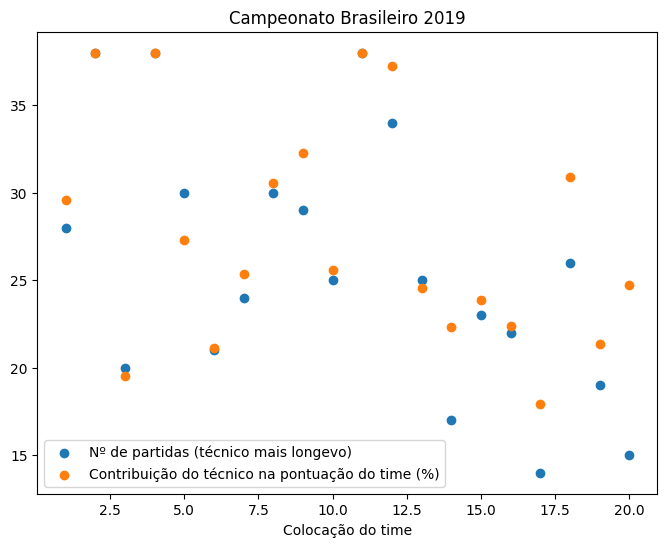

In [15]:
relacao_pontos_tecnicos_mais_longevos_time = [round(pontos / 100 * 38, 2) for pontos in relacao_pontos_tecnicos_mais_longevos_time]

plt.figure(figsize=(8, 6))
plt.title('Campeonato Brasileiro 2019')
plt.xlabel('Colocação do time')

plt.scatter(posicoes, qtd_partidas_tecnicos_mais_longevos, label="Nº de partidas (técnico mais longevo)")
plt.scatter(posicoes, relacao_pontos_tecnicos_mais_longevos_time, label="Contribuição do técnico na pontuação do time (%)")
plt.legend(loc="lower left")
plt.xscale('linear')

## Conclusão

Analisando os dados da tabela e gráfico anteriores, verifica-se que apenas 3 dos técnicos mais longevos (Palmeiras, Athletico-PR, Atlético-MG) de 20 times (15%) obtiveram desempenho inferior em relação à quantidade de partidas jogadas, indicando que a longevidade do técnico está associada à uma pontuação maior em relação ao próprio time.

Outro ponto importante é a relação entre a pontuação dos técnicos mais longevos e a pontuação total dos times. Valores superiores a 80% indicam que a pontuação do time é, em grande parte, atribuível à influência do técnico.

No que concerne aos times com melhores colocações, observamos que estes obtiveram pontuações expressivas, bem acima da média (73% e 42% respectivamente). Casos assim sugerem que a longevidade dos técnicos está associada a um desempenho superior do time, contribuindo para a consistência e excelência deles.

Por outro lado, ao analisar os times com as piores colocações, identificamos um grande variação na frequência dos técnicos mais longevos. Isso sugere que, embora a longevidade do técnico possa ter impacto, outras questões estruturais dentro do clube, como problemas financeiros ou mudanças frequentes na comissão técnica, podem influenciar o desempenho de maneira significativa.

## Reflexões para análises futuras

Para análises futuras, algumas sugestões incluem:

- **Comparar os resultados de diferentes temporadas:** Comparar resultados de outros campeonatos pode ajudar a contextualizar os resultados e identificar tendências ao longo do tempo.
- **Analisar partidas específicas:** Avaliar o desempenho dos times em partidas específicas, especialmente contra adversários clássicos, pode revelar *insights* sobre a capacidade dos técnicos de lidar com situações de pressão e disputas cruciais.
- **Impacto individual dos jogadores:** Analisar o desempenho individual dos jogadores sob a tutela de técnicos mais longevos pode fornecer *insights* sobre a habilidade dos técnicos na gestão de talentos e no desenvolvimento de jogadores.
- **Métricas avançadas:** Analisar métricas avançadas, como posse de bola e eficiência nas finalizações, pode fornecer uma análise mais detalhada do estilo de jogo implementado pelos técnicos e seu impacto no desempenho geral da equipe.